In [1]:
import torch
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    logging,
)
from torchinfo import summary
import json

from collections import Counter
from transformers import logging as transformers_logging

from datasets import load_dataset
from save_results import SaveResults
from read_config import get_args
from utils import set_seed
import warnings
import logging
import random
import numpy as np
import transformers
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

Training on cuda


In [3]:
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
transformers_logging.set_verbosity_error()

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
transformers.set_seed(seed)

In [5]:
# Load the dataset
dataset = load_dataset("multi_woz_v22", trust_remote_code=True)

In [6]:
dataset 

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 8437
    })
    validation: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
})

In [7]:
example = dataset['train'][6]
dialogue = example["turns"]

for speaker, utterance in zip(dialogue["speaker"], dialogue["utterance"]):
    if speaker == 0:  # User input
        print(f" <|user|> {utterance.strip()} ")
    elif speaker == 1:  # System response
        print(f" <|system|> {utterance.strip()}")  # Append system response to context Add endo of text token


 <|user|> Please find me a train from cambridge to stansted airport 
 <|system|> Sure, I can do that but first I need a little more information. What day would you like to travel as well as departure and arrival times?
 <|user|> Saturday leaving Cambridge anytime after 20:00 please 
 <|system|> TR3128 will leave at 20:40 and arrive by 21:08. Do you need more information or would you like to book tickets?
 <|user|> Can you book me 6 tickets please? 
 <|system|> You're all set. Total for tickets is 48.48 GBP payable at the station. Reference number is JD6SA21J .
 <|user|> I am also looking for The Riverside Brasserie. 
 <|system|> riverside brasserie is a modern european restaurant in the centre. Its address is Doubletree by Hilton Cambridge Granta Place Mill Lane and postcode is cb21rt. Want to book it?
 <|user|> Yes, I would like to book it and get a reference number. 
 <|system|> Unfortunately, I cannot book it at this time.
 <|user|> Can you try for Saturday at 13:00? 
 <|system|> Ho

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens_dict = {'additional_special_tokens': ['<|user|>', '<|system|>'], 'pad_token': '<|pad|>'}
tokenizer.add_special_tokens(special_tokens_dict)

3

In [9]:
examples = dataset['train']

dialogues = []
for dialogue in examples['turns']:
    dialogue_text = ""
    for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
        if speaker == 0:  # User input
            dialogue_text += f"<|user|> {utterance.strip()} "
        elif speaker == 1:  # System response
            dialogue_text += f"<|system|> {utterance.strip()} "
    dialogues.append(dialogue_text + "<|endoftext|>")
print("The number of dialogues in the dataset: ", len(dialogues))

The number of dialogues in the dataset:  8437


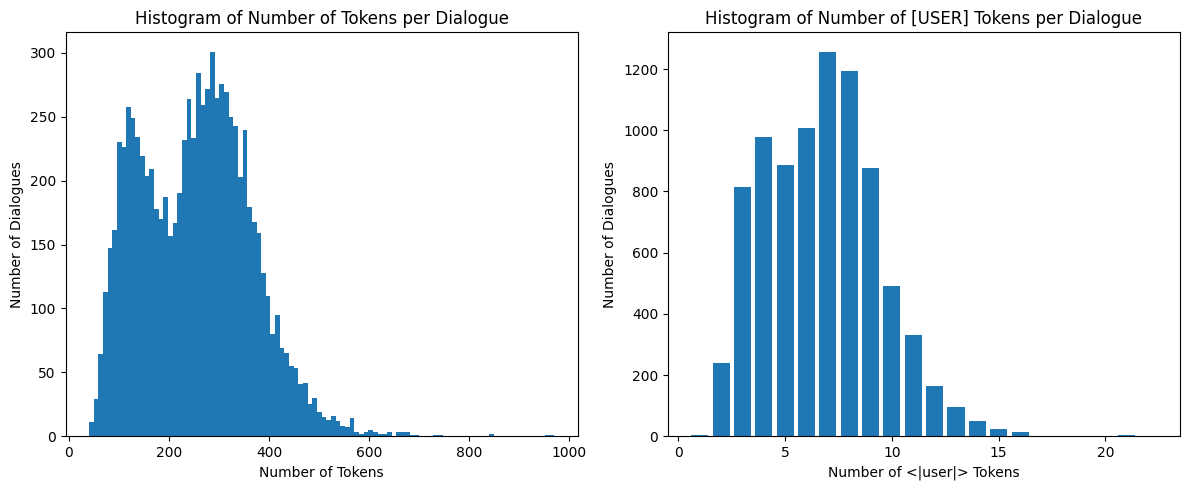

In [10]:
def plot_token_histogram(dialogues, tokenizer, num_bins=10):

    # Tokenizing the dialogues and counting tokens in each dialogue
    num_tokens_per_dialogue = [len(tokenizer.tokenize(dialogue)) for dialogue in dialogues]

    # Create histogram bins
    token_min = min(num_tokens_per_dialogue)
    token_max = max(num_tokens_per_dialogue)
    bins = np.linspace(token_min, token_max, num_bins + 1)  # Create `num_bins` equally spaced bins

    # Count occurrences of each token count
    token_counts, _ = np.histogram(num_tokens_per_dialogue, bins=bins)

    # Count occurrences of [USER] in each dialogue
    num_user_tokens_per_dialogue = [dialogue.count('<|user|>') for dialogue in dialogues]
    user_token_counts = Counter(num_user_tokens_per_dialogue)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the histogram of token counts using bins
    axs[0].bar(bins[:-1], token_counts, width=np.diff(bins), align='edge')  # Plot with bins
    axs[0].set_xlabel('Number of Tokens')
    axs[0].set_ylabel('Number of Dialogues')
    axs[0].set_title('Histogram of Number of Tokens per Dialogue')

    # Plot the histogram of [USER] token counts
    axs[1].bar(user_token_counts.keys(), user_token_counts.values())
    axs[1].set_xlabel('Number of <|user|> Tokens')
    axs[1].set_ylabel('Number of Dialogues')
    axs[1].set_title('Histogram of Number of [USER] Tokens per Dialogue')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_token_histogram(dialogues, tokenizer, num_bins=100)

Prepare the data in a dialogue format with maximum 512 tokens per conversation (this number may be increased to allow longer conversations) and maximum 12 user-bot exchanges per conversation. 

Terminology:
- 1 turn = 1 message (either from the user or the bot)
- 1 user-bot exchange = 2-turn conversation (1 message from the user followed by 1 message from the bot)

In [11]:
def preprocess_data_balanced(examples, max_context_exchanges=12):
    """
    This function processes dialogues and generates a balanced mix of single-turn and multi-turn conversations.
    Handles up to 12 user-bot exchanges (24 turns) in conversations within 512 tokens, ensuring efficient use of context.

    Args:
    - examples: The dataset examples containing dialogues.
    - max_context_exchanges: Maximum number of user-bot exchanges to include in the sliding window (12 user-bot exchanges).

    Returns:
    - tokenized_inputs: Tokenized inputs for training the model.
    """
    dialogues = []

    for dialogue in examples['turns']:
        num_turns = len(dialogue["utterance"])

        # Step 1: Single-turn dialogue (focus on concise bot responses, 1 user-bot exchange = 2 turns)
        for i in range(0, num_turns - 1, 2):  # Each user-bot exchange is 2 turns
            if dialogue["speaker"][i] == 0 and dialogue["speaker"][i + 1] == 1:
                user_utterance = dialogue["utterance"][i].strip()
                bot_response = dialogue["utterance"][i + 1].strip()
                single_turn = f"<|user|> {user_utterance} <|system|> {bot_response} <|endoftext|>"
                dialogues.append(single_turn)

        # Step 2: Multi-turn conversations (sliding window approach with only 1 user-bot exchange overlap)
        # Select windows starting with at least 2 user-bot exchanges (4 turns) up to max_context_exchanges
        for num_exchanges in range(2, min(max_context_exchanges + 1, num_turns // 2 + 1)):  # Sliding window in terms of user-bot exchanges
            for start_turn_index in range(0, num_turns - (num_exchanges * 2) + 1, 2 * (num_exchanges - 1)):  # Ensure valid window sizes
                dialogue_text = ""
                for exchange_index in range(num_exchanges):  # Each iteration captures 1 user-bot exchange (2 turns)
                    user_utterance = dialogue["utterance"][start_turn_index + 2 * exchange_index].strip()
                    bot_response = dialogue["utterance"][start_turn_index + 2 * exchange_index + 1].strip()
                    dialogue_text += f"<|user|> {user_utterance} <|system|> {bot_response} "
                dialogues.append(dialogue_text + "<|endoftext|>")

    # Tokenize the combined dialogue list
    tokenized_inputs = tokenizer(dialogues, padding="max_length", truncation=True, max_length=512)  # Max length set to 512
    
    # Add labels as a copy of input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()

    return tokenized_inputs

In [12]:
train_data = dataset['train'].map(lambda x: preprocess_data_balanced(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])
val_data = dataset['validation'].map(lambda x: preprocess_data_balanced(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])

train_data = train_data.shuffle(seed=42)
val_data = val_data.shuffle(seed=42)

Map:   0%|          | 0/8437 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 167683
})

In [14]:
print("There are", train_data.num_rows, "conversations in total.")

There are 167683 conversations in total.


Detokenize a few examples from the tokenized train_data:

In [15]:
for i in range(2):  # Adjust the range if you want more or fewer examples
    input_ids = train_data[i]['input_ids']
    
    # Filter out the padding tokens manually
    input_ids_no_pad = [token_id for token_id in input_ids if token_id != tokenizer.pad_token_id]
    
    # Detokenize the sequence without the padding tokens
    detokenized_sentence = tokenizer.decode(input_ids_no_pad, skip_special_tokens=False)
    
    print(f"Example {i + 1}: {detokenized_sentence}")

Example 1: <|user|>  I will also need to book a taxi.  <|system|>  I can do that! I just need your departure and arrival sites and the time you need the taxi.  <|user|>  I'd like to leave the museum in time to get to the restaurant on time.  <|system|>  Okay, you have a car that will come get you. It will be a blue BMW.  <|user|>  What is their contact number?  <|system|>  The contact number is 07601724141. Is there anything else I can help with today? <|endoftext|>
Example 2: <|user|>  What about architecture in the centre?  <|system|>  I recommendvLittle saint mary's church don't let the name fool you, they are large and have a lot to see, would you like more information?  <|user|>  Can I get the address, please?  <|system|>  The address is Little Saint Mary's Lane. Is there anything else you need to know?  <|user|>  No thank you that will be all  <|system|>  It was nice talking to you. If you need assistance in the future, please don't hesitate to text us again. Goodbye! <|endoftext

# The GPT model

In [16]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

In [17]:
summary(model, input_data=torch.zeros((1, 512), dtype=torch.long), device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    [1, 12, 512, 64]          --
├─GPT2Model: 1-1                                   [1, 12, 512, 64]          --
│    └─Embedding: 2-1                              [1, 512, 768]             38,599,680
│    └─Embedding: 2-2                              [1, 512, 768]             786,432
│    └─Dropout: 2-3                                [1, 512, 768]             --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-2                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-3                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-4                         [1, 512, 768]             7,087,872
│    │    └─GPT2Block: 3-5                         [1, 512, 768]          

In [18]:
training_args = TrainingArguments(
    output_dir="ensemble_results/MyGPT2chat",  # Directory to save the model checkpoints and other outputs.
    max_steps=1000,  # Total number of training steps. The model will stop training once this number is reached.
    optim="adamw_torch",  # Optimizer to use during training. 'adamw_torch' refers to AdamW implemented in PyTorch.
    learning_rate=5e-5,  # Learning rate used for the optimizer, which controls how much to adjust the weights with respect to the gradient.
    weight_decay=0.01,  # Weight decay (L2 regularization) to prevent overfitting by penalizing large weights.
    per_device_train_batch_size=16,  # Number of samples per batch for training on each device (e.g., GPU).
    per_device_eval_batch_size=16,  # Number of samples per batch for evaluation on each device.
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating model weights, allowing larger effective batch sizes.
    gradient_checkpointing=True,  # Save memory by checkpointing gradients, which trades compute time for memory.
    warmup_steps=100,  # Number of warmup steps during which the learning rate linearly increases from 0 to the specified value.
    lr_scheduler_type="linear",  # Learning rate schedule, with 'linear' meaning it decreases linearly after the warmup phase.
    evaluation_strategy="steps",  # Perform evaluation at regular steps, as opposed to other strategies like 'epoch'.
    eval_steps=50,  # Number of training steps between evaluations (to check performance on the validation set).
    logging_steps=50,  # Number of steps between logging events, used to monitor training progress.
    log_level="info",  # The verbosity of logging, 'passive' logging will only occur if you manually enable it.
    save_steps=100,  # Number of steps between saving model checkpoints.
    save_total_limit=2,  # Maximum number of model checkpoints to keep. Older checkpoints will be deleted when this limit is exceeded.
    disable_tqdm=False,  # Whether or not to disable the progress bar ('tqdm'). False means the progress bar will be displayed.
    report_to="none",  # This ensures no reporting to any integrations
)

/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=val_data)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


max_steps is given, it will override any value given in num_train_epochs


In [20]:
train_now = "TRUE"

In [21]:
if train_now == "TRUE":
    trainer.train()
    model.save_pretrained("ensemble_results/MyGPT2chat")
    tokenizer.save_pretrained("ensemble_results/MyGPT2chat")
    log_history = trainer.state.log_history
    with open("ensemble_results/MyGPT2chat/"+'log_history.json', 'w') as f: json.dump(log_history, f)
else:
    with open("ensemble_results/MyGPT2chat/"+'log_history.json', 'r') as f: log_history = json.load(f) 

***** Running training *****


  Num examples = 167,683


  Num Epochs = 1


  Instantaneous batch size per device = 16


  Total train batch size (w. parallel, distributed & accumulation) = 64


  Gradient Accumulation steps = 4


  Total optimization steps = 1,000


  Number of trainable parameters = 124,442,112


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,12.042500,1.183190
100,0.717000,0.538305
150,0.501400,0.471297
200,0.468100,0.445502
250,0.454500,0.429893
300,0.422700,0.418143
350,0.419700,0.409021
400,0.412000,0.401233
450,0.409100,0.394910
500,0.399100,0.390572


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-100


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-100/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-100/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-100/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-100/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-100/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-100] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-200


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-200/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-200/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-200/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-200/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-200/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-200] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-300


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-300/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-300/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-300/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-300/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-300/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-300] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-400


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-400/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-400/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-400/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-400/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-400/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-400] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-500


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-500/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-500/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-500/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-500/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-500/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-500] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-600


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-600/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-600/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-600/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-600/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-600/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-600] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-700


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-700/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-700/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-700/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-700/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-700/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-700] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-800


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-800/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-800/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-800/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-800/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-800/added_tokens.json


Deleting older checkpoint [ensemble_results/MyGPT2chat/checkpoint-800] due to args.save_total_limit


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-900


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-900/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-900/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-900/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-900/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-900/added_tokens.json


/work/FAC/FGSE/IDYST/gjouvet/default/klleshi/.conda/envs/NLP/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


***** Running Evaluation *****


  Num examples = 22256


  Batch size = 16


Saving model checkpoint to ensemble_results/MyGPT2chat/checkpoint-1000


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-1000/config.json


Configuration saved in ensemble_results/MyGPT2chat/checkpoint-1000/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/checkpoint-1000/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/checkpoint-1000/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/checkpoint-1000/added_tokens.json




Training completed. Do not forget to share your model on huggingface.co/models =)




Configuration saved in ensemble_results/MyGPT2chat/config.json


Configuration saved in ensemble_results/MyGPT2chat/generation_config.json


tokenizer config file saved in ensemble_results/MyGPT2chat/tokenizer_config.json


Special tokens file saved in ensemble_results/MyGPT2chat/special_tokens_map.json


added tokens file saved in ensemble_results/MyGPT2chat/added_tokens.json


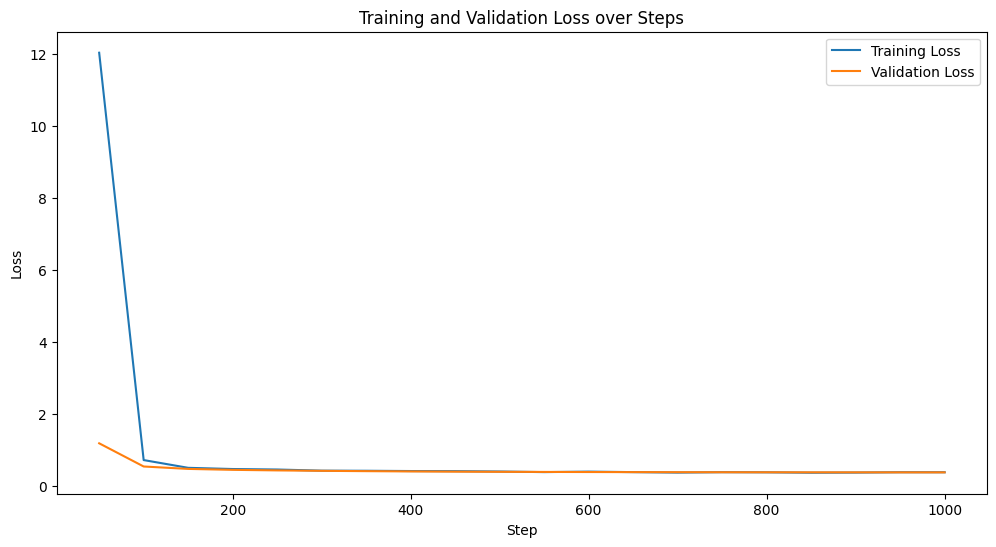

In [22]:
steps = sorted(set(log['step'] for log in log_history if 'step' in log))
losses = [log['loss'] for log in log_history if 'loss' in log]
val_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Steps')
plt.savefig("ensemble_results/MyGPT2chat/loss_curves.png", format='png')
plt.show()